In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256, cuda=cuda, normalize=True)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda, normalize=True)
trainC = ConcatDataset([trainL,trainU])

In [6]:
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda, normalize=True)
valL = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda, normalize=True)

trainL = DataLoader(trainL,64,True)
train = DataLoader(train,64,True)
val = DataLoader(val,64,True)
test = DataLoader(test,64,True)
valL = DataLoader(valL,64,True)

In [7]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 256 x 32 x 32
        )
        # Decoder: Deconvolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),  # Output 2 channels (a, b)
            nn.Tanh()  # Normalize output to range [-1, 1]
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

In [8]:
img = next(iter(train))[0]
print(img.shape)
img = img[0]
print(img.shape)
print(img)
img = img.cpu().numpy()

torch.Size([64, 3, 256, 256])
torch.Size([3, 256, 256])
tensor([[[1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210],
         [1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210],
         [1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210],
         ...,
         [1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210],
         [1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210],
         [1.3210, 1.3210, 1.3210,  ..., 1.3210, 1.3210, 1.3210]],

        [[1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817],
         [1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817],
         [1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817],
         ...,
         [1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817],
         [1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817],
         [1.5817, 1.5817, 1.5817,  ..., 1.5817, 1.5817, 1.5817]],

        [[1.7656, 1.7656, 1.7656,  ..., 1.7656, 1.7656, 1.7656],
         [1.7656, 1.7656, 1.7656,  ..., 1.7656, 1.7656, 1.7656],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6512237..2.1235957].


(3, 256, 256)


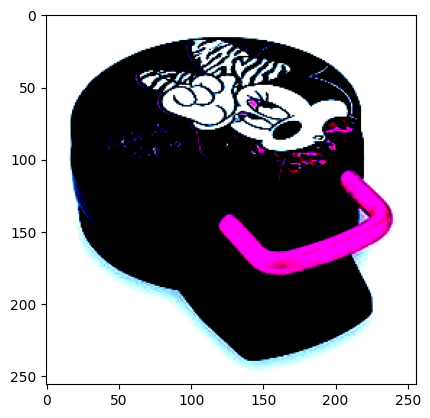

(256, 256, 3)
[[0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]
 [0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]
 [0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]
 ...
 [0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]
 [0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]
 [0.39215687 0.39215687 0.39215687 ... 0.39215687 0.39215687 0.39215687]]
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


In [9]:

print(img.shape)
img = np.moveaxis(img, 0, 2)
plt.imshow(img)
plt.show()
print(img.shape)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
L = lab[:,:,0]/255.0
ab = lab[:,:,1:]/128.0
print(L)
print(ab)

In [8]:
def process_batch(batch):
    batch = batch.cpu().numpy()
    batch = np.moveaxis(batch, 1, -1)  # Move channel axis to the end
    lab_batch = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in batch])
    
    L_batch = lab_batch[:,:,:,0] / 255.0
    ab_batch = lab_batch[:,:,:,1:] / 128.0
    
    L_batch = torch.tensor(L_batch, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    ab_batch = torch.tensor(ab_batch, dtype=torch.float32).permute(0, 3, 1, 2)  # Move channel axis to the second position
    
    return L_batch, ab_batch


In [11]:
batch = next(iter(train))
L_batch,ab_batch = process_batch(batch[0])

In [12]:
print(L_batch.shape)
print(ab_batch.shape)

torch.Size([64, 1, 256, 256])
torch.Size([64, 2, 256, 256])


In [10]:
best_model_path = 'self-supervised/models/best_Colorizer.pth'  # Path to save the best model

In [ ]:
colorizer = ColorizationModel()

optimizer = torch.optim.Adam(colorizer.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Reconstruction loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
colorizer.to(device)

# Free all cuda memory that can be freed
torch.cuda.empty_cache()

train_loss = []
val_loss = []

num_epochs = 10
best_val_loss = float('inf')  # Initialize the best validation loss to infinity


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    colorizer.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs, _ in train:
        # Clear the cache at the start of each loop
        torch.cuda.empty_cache()
        
        i = i + 1
        if i % 50 == 0:
            print(f'Batch {i} di {len(train)}')
        L, ab = process_batch(inputs)
        L = L.to(device)
        ab = ab.to(device)
        optimizer.zero_grad()
        outputs = colorizer(L)
        loss = criterion(outputs, ab)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_epoch = running_loss / len(train)
    print(f'Train_Loss: {train_loss_epoch}')
    train_loss.append(train_loss_epoch)
    
    colorizer.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs, _ in val:
        # Clear the cache at the start of each loop
        torch.cuda.empty_cache()
        
        i = i + 1
        if i % 50 == 0:
            print(f'Batch {i} di {len(val)}')
        L, ab = process_batch(inputs)
        L = L.to(device)
        ab = ab.to(device)
        outputs = colorizer(L)
        loss = criterion(outputs, ab)
        running_loss += loss.item()
    val_loss_epoch = running_loss / len(val)
    print(f'Validation_Loss: {val_loss_epoch}')
    val_loss.append(val_loss_epoch)

    # Save the model if the validation loss improves
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(colorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch 1
Training:
Batch 50 di 1469
Batch 100 di 1469
Batch 150 di 1469
Batch 200 di 1469
Batch 250 di 1469
Batch 300 di 1469
Batch 350 di 1469
Batch 400 di 1469
Batch 450 di 1469
Batch 500 di 1469
Batch 550 di 1469
Batch 600 di 1469
Batch 650 di 1469
Batch 700 di 1469
Batch 750 di 1469
Batch 800 di 1469
Batch 850 di 1469
Batch 900 di 1469
Batch 950 di 1469
Batch 1000 di 1469
Batch 1050 di 1469
Batch 1100 di 1469
Batch 1150 di 1469
Batch 1200 di 1469
Batch 1250 di 1469
Batch 1300 di 1469
Batch 1350 di 1469
Batch 1400 di 1469
Batch 1450 di 1469
Train_Loss: 0.03233391049186781
Validation:
Batch 50 di 368
Batch 100 di 368
Batch 150 di 368
Batch 200 di 368
Batch 250 di 368
Batch 300 di 368
Batch 350 di 368
Validation_Loss: 0.0326269948652581
Best model saved with validation loss: 0.0326269948652581
Epoch 2
Training:
Batch 50 di 1469
Batch 100 di 1469
Batch 150 di 1469
Batch 200 di 1469
Batch 250 di 1469
Batch 300 di 1469
Batch 350 di 1469
Batch 400 di 1469
Batch 450 di 1469
Batch 500 di 146

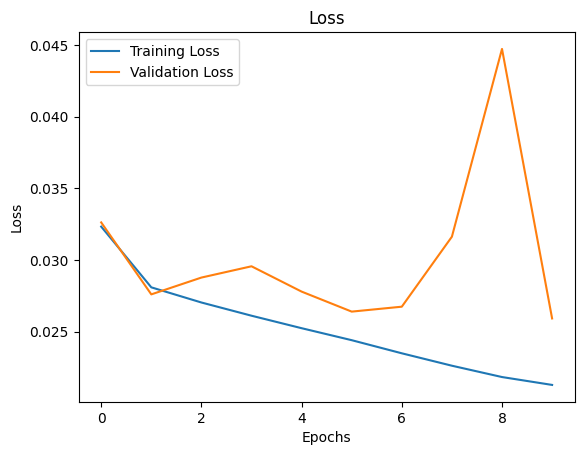

In [14]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)

In [58]:
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
def show_reconstruction(model, dataloader):
    """
    Function to display the original and reconstructed images
    :param model: Sparse Autoencoder model
    :param dataloader: DataLoader containing the images
    """
    model.eval()
    for i, (inputs, _) in enumerate(dataloader):
        if i >= 4:
            break
        L, ab = process_batch(inputs)
        L = L.to(device)
        with torch.no_grad():
            outputs = model(L)
        
        # Compose the Lab image
        L = L.cpu().numpy()
        ab = outputs.cpu().numpy()
        Lab = np.concatenate((L, ab), axis=1)
        print(Lab.shape)
        Lab = np.moveaxis(Lab, 1, -1)  # Move channel axis to the end
        print(Lab.shape)
        Lab[:, :, 0] = (Lab[:, :, 0] * 255).astype(np.uint8)
        Lab[:, :, 1:] = (Lab[:, :, 1:] * 128).astype(np.uint8)
        print(Lab.shape)
        rgb_image = cv2.cvtColor(Lab[0], cv2.COLOR_LAB2RGB)
        print(rgb_image.shape)
        show_image(inputs[0])
        show_image(rgb_image)

In [18]:
colorizer = ColorizationModel()
colorizer.load_state_dict(torch.load(best_model_path))

RuntimeError: Error(s) in loading state_dict for ColorizationModel:
	Missing key(s) in state_dict: "decoder.0.weight", "decoder.0.bias", "decoder.1.weight", "decoder.1.bias", "decoder.1.running_mean", "decoder.1.running_var", "decoder.3.weight", "decoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.4.running_mean", "decoder.4.running_var", "decoder.6.weight", "decoder.6.bias". 
	Unexpected key(s) in state_dict: "ff1.weight", "ff1.bias", "ff2.weight", "ff2.bias". 

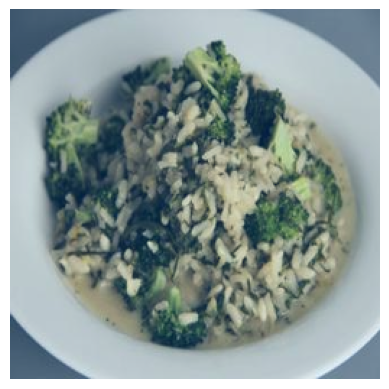

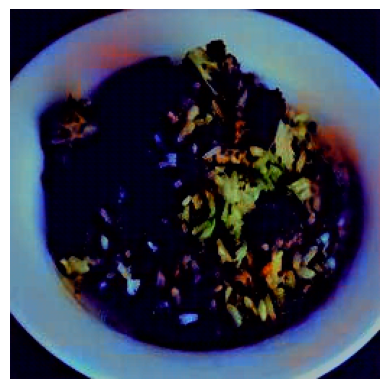

In [98]:
batch = next(iter(train))[0]
L_batch,ab_batch = process_batch(batch)
L_batch = L_batch.to(device)
with torch.no_grad():
    ab = colorizer(L_batch)
ab = ab.cpu().numpy()
L_batch = L_batch.cpu().numpy()
Lab = np.concatenate((L_batch, ab), axis=1)
batch = batch.cpu().numpy()
def renormalize(tensor):
    minFrom = tensor.min()
    maxFrom = tensor.max()
    minTo = 0
    maxTo = 1
    return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))
Lab = Lab[0]
batch = renormalize(batch[0])
Lab = np.moveaxis(Lab, 0, -1)
rgb_image = cv2.cvtColor(Lab, cv2.COLOR_LAB2RGB)
rgb_image = renormalize(rgb_image)
rgb_image = np.moveaxis(rgb_image, -1, 0)
show_image(batch)
show_image(rgb_image)


In [107]:
class ExtendedColorizer(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizer, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.ff2(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [108]:
exColorizer = ExtendedColorizer(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-5)
best_model_path = 'self-supervised/models/best_Colorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        inputs,_ = process_batch(inputs)
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.526023811764187, Accuracy: 0.34860557768924305%
Validation:
Batch 10 di 16
Validation Loss: 5.5253066420555115, Accuracy: 0.398406374501992%
Best model saved with validation loss: 5.5253066420555115
Epoch: 2
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.524795509520031, Accuracy: 0.47310756972111556%
Validation:
Batch 10 di 16
Validation Loss: 5.5252366065979, Accuracy: 0.6972111553784861%
Best model saved with validation loss: 5.5252366065979
Epoch: 3
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.521479773142981, Accuracy: 0.9711155378486056%
Validation:
Batch 10 di 16
Validation Loss: 5.524666965007782, Accuracy: 0.6972111553784861%
Best model saved with validation loss: 5.524666965007782
Epoch: 4
Training:
Batch 10 di 6

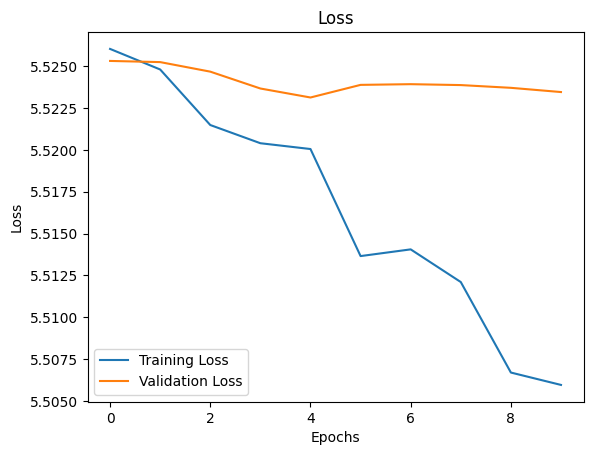

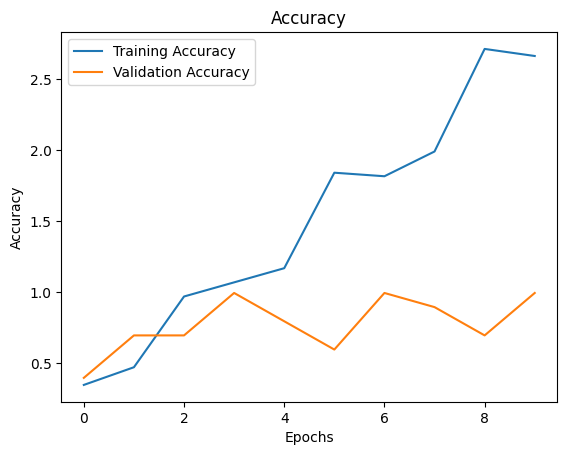

In [109]:
plot_loss(train_loss,val_loss)
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
plot_accuracy(train_acc,val_acc)

In [13]:
class ExtendedColorizerLinear(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizerLinear, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [16]:
exColorizer = ExtendedColorizerLinear(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-5)
best_model_path = 'self-supervised/models/best_LinearColorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        inputs,_ = process_batch(inputs)
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.9310703958783835, Accuracy: 0.37350597609561753%
Validation:
Batch 10 di 16
Validation Loss: 6.927530527114868, Accuracy: 0.49800796812749004%
Best model saved with validation loss: 6.927530527114868
Epoch: 2
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.912907244667174, Accuracy: 3.8595617529880477%
Validation:
Batch 10 di 16
Validation Loss: 6.92712676525116, Accuracy: 0.49800796812749004%
Best model saved with validation loss: 6.92712676525116
Epoch: 3
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.8757715755038795, Accuracy: 6.947211155378486%
Validation:
Batch 10 di 16
Validation Loss: 6.926151931285858, Accuracy: 0.6972111553784861%
Best model saved with validation loss: 6.926151931285858
Epoch: 4
Training:
Batch 10 d

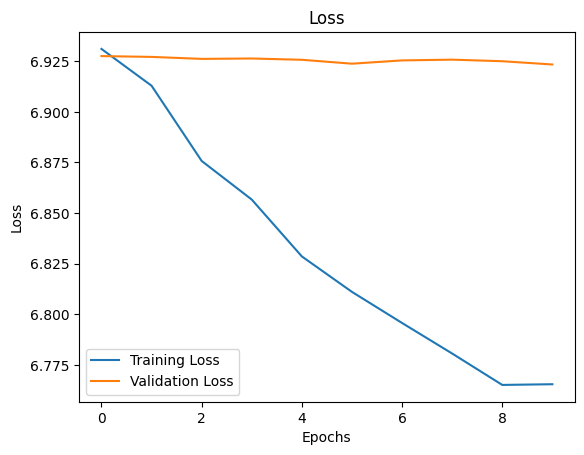

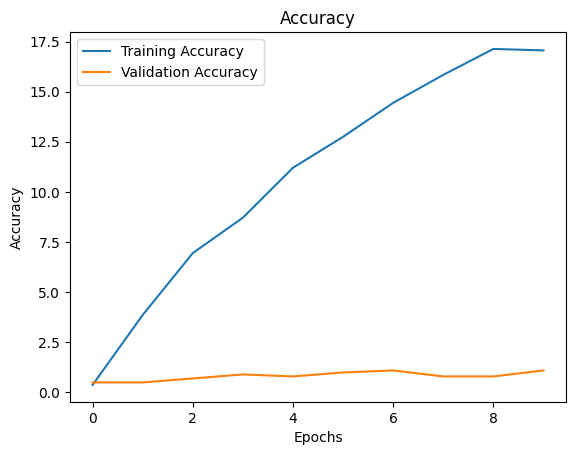

In [17]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)